# Нейронна мережа для класифікації зображень
- тип - згорткова
- датасет для навчання - CIFAR-10 (60000 кольорових зображень розміром 32x32, розбитих на 10 класів по 6000 прикладів на клас)
- класифікація відбувається по класах: airplane, car, bird, cat, deer, dog, frog, horse, ship and trucks
- використано передвиборну мережу VGG16


#### Частина 1. Підготовка даних та створення згорткової моделі

#### 1.1. Завантаження і підготовка даних

In [55]:
from tensorflow import keras

from keras.datasets import cifar10

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization, Dropout

import numpy as np

import matplotlib.pyplot as plt

In [56]:
# Розпакування даних з load_data на тренувальні та тестові дані, а також відповідні мітки (labels)
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [57]:
# Вивід розмірів тренувальної і тестової вибірки
print('Розміри тренувальної вибірки:', x_train.shape, y_train.shape)
print('Розміри тестової вибірки:', x_test.shape, y_test.shape)

Розміри тренувальної вибірки: (50000, 32, 32, 3) (50000, 1)
Розміри тестової вибірки: (10000, 32, 32, 3) (10000, 1)


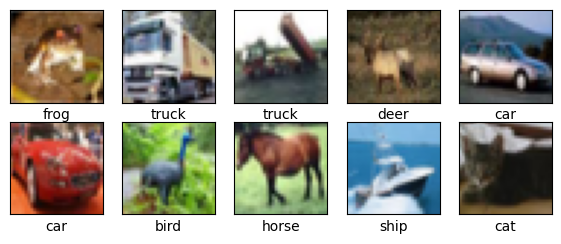

In [58]:
# Покажемо, для загального уявлення, перщі 10 зображень з відповідними мітками з тренувальної вибірки
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(7, 7))
for i in range(10):
    plt.subplot(5, 5, i + 1)  # визначає сітку 5x5 підзображень у великому зображенні
    plt.xticks([])  # вимикання координатних числових підписів
    plt.yticks([])
    plt.imshow(x_train[i])  # відображення картинки
    plt.xlabel(class_names[y_train[i][0]])  # підписування картинки міткою класу
plt.show()

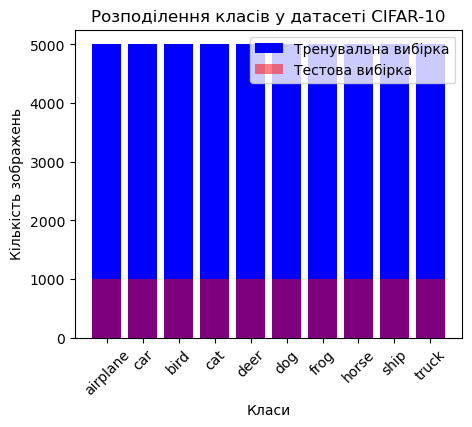

In [59]:
# Проаналізуємо розподілення даних по класах для тренувальної та тестової вибірок
train_class_counts = np.bincount(y_train.flatten())  # кількість зображень у кожному класі для тренувальної вибірки
test_class_counts = np.bincount(y_test.flatten())  # кількість зображень у кожному класі для тестової вибірки

# Візуалізація розподілення класів
plt.figure(figsize=(5, 4))
plt.bar(np.arange(len(class_names)), train_class_counts, color='blue', label='Тренувальна вибірка')
plt.bar(np.arange(len(class_names)), test_class_counts, color='red', alpha=0.5, label='Тестова вибірка')
plt.xlabel('Класи')
plt.ylabel('Кількість зображень')
plt.title('Розподілення класів у датасеті CIFAR-10')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.legend()
plt.show()

Як видно, датасет добре збалансований.

In [60]:
# Виконаємо нормалізацію даних перед їх передачею у згорткову модель
x_train, x_test = x_train / 255., x_test / 255.

#### 1.2. Створення згорткової моделі

In [61]:
model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same',  activation='relu', kernel_initializer='he_normal', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
# створюється 32 фільтри розміром (3,3), які рухаються по вхідному зображенню
# padding='same' вказує на додавання нулів до країв зображення
# kernel_initializer='he_normal' - ініціалізує ваги шару так, що дисперсія вихідних значень активацій зберігається після проходження через шар
# використовується пулінг з розміром (2, 2), що веде до зменшення розміру кожного зображення у два рази

model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

/home/alex/Python_projects/HW_Data_Science/.conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [62]:
# Візуалізуємо шарову структуру моделі
# !pip install visualkeras

# import visualkeras

# visualkeras.layered_view(model)

In [63]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)        │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)        │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)       │     36,992 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_3           │ (None, 8192)              │     32,768 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 512)               │  4,194,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_5 (Dropout)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_7 (Dense)                 │ (None, 10)                │      5,130 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 4,418,314 (16.85 MB)

 Trainable params: 4,401,866 (16.79 MB)

 Non-trainable params: 16,448 (64.25 KB)

In [64]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
    )

In [65]:
model_name = 'model_1'

history = model.fit(x_train, y_train,  batch_size=128, epochs=10, validation_split=0.2)

# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
 16/313 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.8742 - sparse_categorical_accuracy: 0.2123

W0000 00:00:1707493351.206974   23768 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.1671 - sparse_categorical_accuracy: 0.3636

W0000 00:00:1707493357.954724   23765 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1707493358.719215   23769 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 2.1658 - sparse_categorical_accuracy: 0.3638 - val_loss: 3.8298 - val_sparse_categorical_accuracy: 0.1924
Epoch 2/10
 16/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.1928 - sparse_categorical_accuracy: 0.5728

W0000 00:00:1707493359.260886   23767 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.1723 - sparse_categorical_accuracy: 0.5813 - val_loss: 1.0070 - val_sparse_categorical_accuracy: 0.6492
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0066 - sparse_categorical_accuracy: 0.6408 - val_loss: 1.1257 - val_sparse_categorical_accuracy: 0.6228
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8919 - sparse_categorical_accuracy: 0.6858 - val_loss: 1.0330 - val_sparse_categorical_accuracy: 0.6571
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.8013 - sparse_categorical_accuracy: 0.7138 - val_loss: 0.7948 - val_sparse_categorical_accuracy: 0.7256
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7184 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.7915 - val_sparse_categorical_accuracy: 0.7276
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.6476 - sparse_categorical_accuracy: 0.7715 - val_loss: 0.7989 - val_sparse_categorical_accuracy: 0.7265
Epoch 8/1

W0000 00:00:1707493393.416490   23763 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7917 - sparse_categorical_accuracy: 0.7366
Test accuracy: 0.7414000034332275


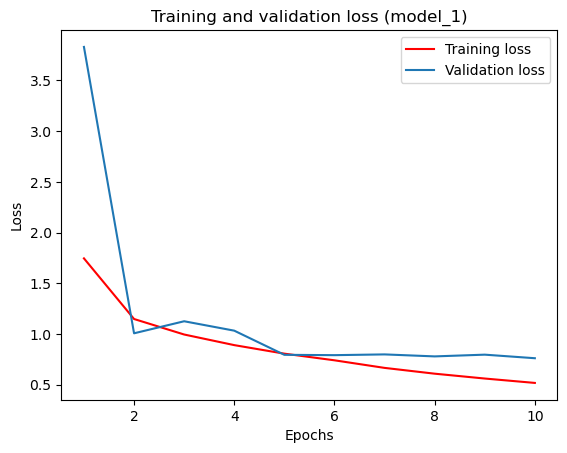

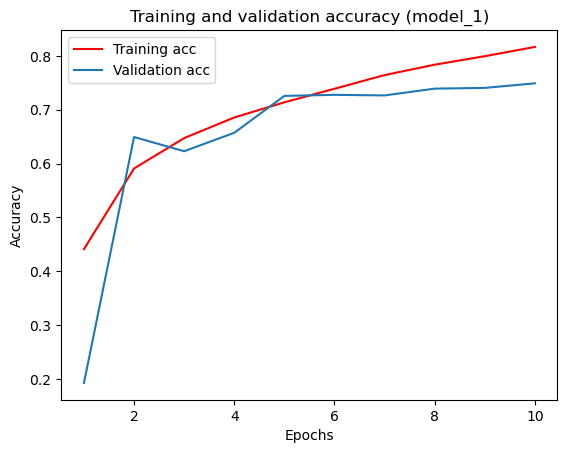

In [66]:
# Візуалізуємо результати навчання

history_dict = history.history

epochs = range(1, len(history_dict['sparse_categorical_accuracy']) + 1)

plt.plot(epochs, history_dict['loss'], label='Training loss', color="r")
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], label='Training acc', color="r")
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], label='Validation acc')
plt.title(f'Training and validation accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Точність моделі можна покращити. Для цього використаємо VGG16 в якості згорткової основи. Застосуємо прийоми донавчання та виділення ознак.

#### 1.3. Згорткова модель з попередньо навченою мережею VGG16
VGG16 очікує кольорові зображення розміром 32x32, тому для датасету CIFAR-10 не потрібно змінювати розмір вхідних даних.

#### 1.3.1. Виділення ознак (feature extraction)
Полягає в тому, щоб взяти основу попередньо навченої мережі, потім "прикріпити" до неї повнозв'язний класифікатор і навчити його на нових даних.

In [67]:
# Забезпечення сумісності даних CIFAR-10 з VGG16
from keras.utils import to_categorical

# Перетворення міток в категоріальний формат
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

In [68]:
from keras.applications.vgg16 import VGG16

# Створення VGG16 без верхнього повнозв'язаного шару
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# weights='imagenet': ваги моделі повинні завантажуватися з попередньо навченої моделі на наборі даних ImageNet.
# ImageNet - це великий набір даних для розпізнавання об'єктів, який включає тисячі класів.
# Ваги, навчені на ImageNet, можуть бути використані як ефективний вихідний пункт для подальших завдань.
# include_top=False: верхні (fully connected) шари моделі (які відповідають за класифікацію в тисячах класів ImageNet)
# не повинні включатися. Ми  додаватимемо свій власний классифікатор поверх цієї згорткової основи, і тому верхні шари не потрібні.
# input_shape=(32, 32, 3): розмір вхідних зображень, які використовуються.
# У цьому випадку припускається, що вхідні зображення мають розмір 48x48 пікселів і три канали (RGB).

# Заморожуємо ваги базової моделі
conv_base.trainable = False

In [69]:
# Створимо згорткову нейромережу, що використовує VGG16 як згортковий шар
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Для 10 класів CIFAR-10

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)

In [70]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                         │ 14,714,688 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_4 (Flatten)             │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [71]:
# Візуалізуємо шарову структуру моделі
# !pip install visualkeras

# import visualkeras

# visualkeras.layered_view(model)

In [72]:
model_name = 'model_2'

history = model.fit(x_train, train_labels, epochs=10, batch_size=128, validation_split=0.5)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.1410 - loss: 2.3791 - val_accuracy: 0.2261 - val_loss: 2.1960
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2469 - loss: 2.1660 - val_accuracy: 0.3223 - val_loss: 2.0706
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.3348 - loss: 2.0450 - val_accuracy: 0.3727 - val_loss: 1.9672
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.3745 - loss: 1.9448 - val_accuracy: 0.4036 - val_loss: 1.8780
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4066 - loss: 1.8595 - val_accuracy: 0.4202 - val_loss: 1.8040
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4200 - loss: 1.7914 - val_accuracy: 0.4366 - val_loss: 1.7447
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4362 - loss: 1.7306 - val_accuracy: 0.4456 - val_loss: 1.6957
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.4444 - loss: 1.6818 - val_accu

In [73]:
# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(x_test, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4620 - loss: 1.6041
Test accuracy: 0.46050000190734863


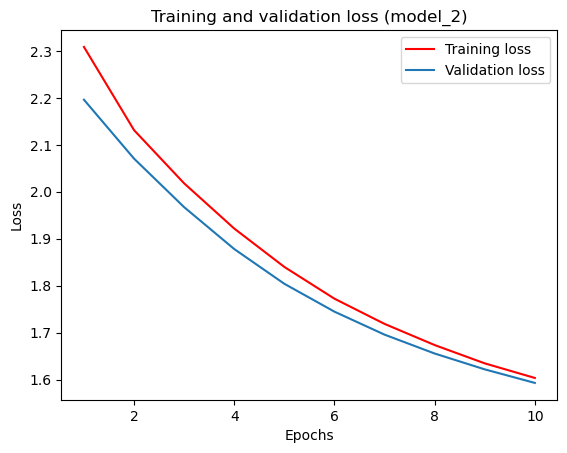

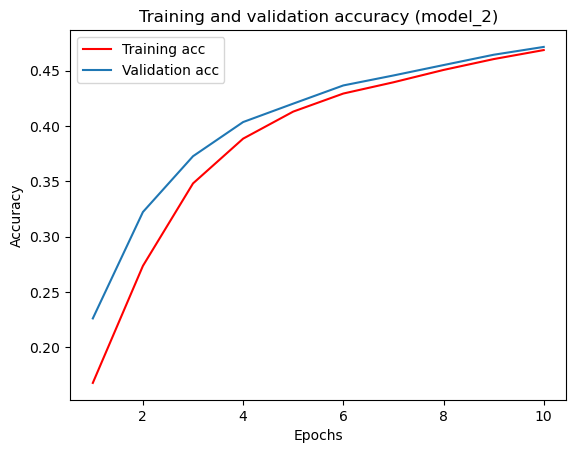

In [74]:
# Візуалізуємо результати навчання
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, history_dict['loss'], label='Training loss', color="r")
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, history_dict['accuracy'], label='Training acc', color="r")
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title(f'Training and validation accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Бачимо, що використання в якості основи згорткової мережі VGG16, при навчанні протягом 10 епох, дає точність ..............%. Далі застосуємо прийом донавчання.

#### 1.3.2. Донавчання нейромережі з основою VGG16
Цей підхід полягає в "розморожуванні" декількох верхніх шарів замороженої моделі, яка використовувалася для виділення ознак, і спільному навчанні нової доданої частини моделі (в даному випадку повнозв'язкового класифікатора) і цих верхніх шарів.

Для донавчання мережі потрібно виконати такі кроки:

- додати свою мережу поверх навченої базової мережі;
- заморозити базову мережу;
- навчити додану частину;
- розморозити кілька шарів у базовій мережі;
- навчити ці шари та додану частину разом.

Ми вже виконали перші три кроки, коли виділяли ознаки. Тепер виконаємо четвертий крок розморозивши кілька шарів у conv_base.

In [75]:
# Подивимося архітектуру нашої згорткової основи
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)        │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)        │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)         │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)         │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)         │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)         │          0 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [76]:
# Виконаємо донавчання останніх трьох шарів, а саме: block5_conv1, block5_conv2 та block5_conv3.
# Інші шари залишимо без змін.
conv_base.trainable = True  # всі шари (layers) моделі conv_base тепер можна тренувати
set_trainable = False  # встановлює початкове значення змінної, яка буде використовуватися для визначення того, чи ми повинні тренувати певний шар
for layer in conv_base.layers:  # перебирає всі шари в моделі conv_base
    if layer.name == "block5_conv1":
        set_trainable = True  # якщо поточний шар має ім'я "block5_conv1", то встановлює змінну set_trainable в значення True (це означає, що всі наступні шари будуть тренуватися)
    if set_trainable:
        layer.trainable = True  # встановлюється можливість тренування для поточного шару
    else:
        layer.trainable = False  # поточний шар "заморожується"

In [77]:
# Створимо модифіковану згорткову нейромережу
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))  # Для 10 класів CIFAR-10

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)

In [78]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)         │ 14,714,688 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_5 (Flatten)             │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [79]:
# Візуалізуємо шарову структуру моделі
# !pip install visualkeras

# import visualkeras

# visualkeras.layered_view(model)

In [80]:
model_name = 'model_cifar10_vgg16'

history = model.fit(x_train, train_labels, epochs=15, batch_size=32, validation_split=0.2)

Epoch 1/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.5033 - loss: 1.4369 - val_accuracy: 0.6667 - val_loss: 0.9484
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.6940 - loss: 0.8789 - val_accuracy: 0.7002 - val_loss: 0.8544
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7391 - loss: 0.7498 - val_accuracy: 0.7163 - val_loss: 0.8157
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7674 - loss: 0.6641 - val_accuracy: 0.7347 - val_loss: 0.7702
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7925 - loss: 0.5957 - val_accuracy: 0.7347 - val_loss: 0.7720
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.8140 - loss: 0.5313 - val_accuracy: 0.7456 - val_loss: 0.7467
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.8324 - loss: 0.4752 - val_accuracy: 0.7490 - val_loss: 0.7445
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.8587 -

In [81]:
# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(x_test, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7464 - loss: 1.0435
Test accuracy: 0.7419999837875366


In [91]:
# Збереження навченої моделі

import tensorflow as tf

model.save("/home/alex/Python_projects/HW_Data_Science/models/model_cifar10_vgg16.keras")

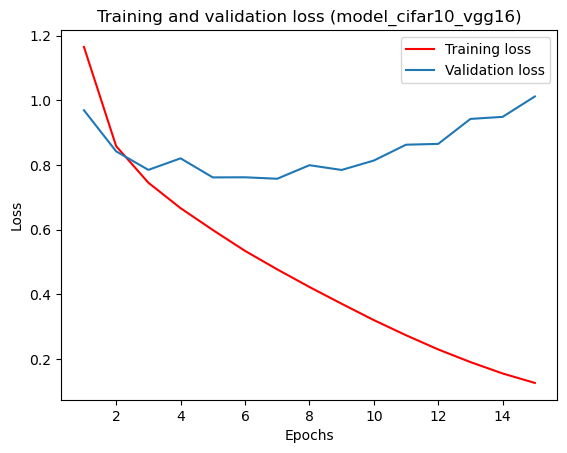

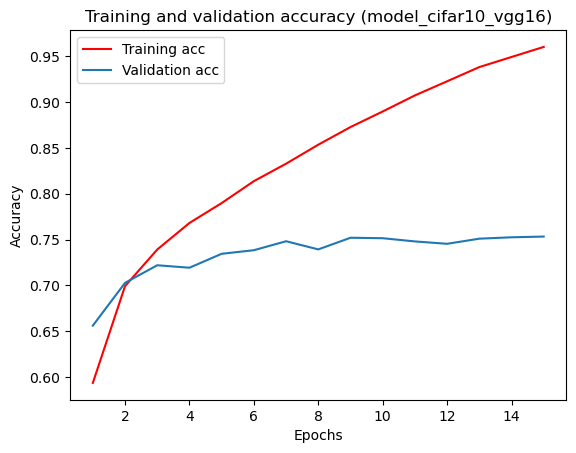

In [ ]:
# Візуалізуємо результати навчання
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, history_dict['loss'], label='Training loss', color="r")
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, history_dict['accuracy'], label='Training acc', color="r")
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title(f'Training and validation accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Наведемо Confusion Matrix для розуміння якості моделі по різних класах.

In [86]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.15.0


In [93]:
# new_model = tf.keras.models.load_model('/home/alex/Python_projects/HW_Data_Science/models/model_cifar10_vgg16')
new_model = keras.models.load_model("/home/alex/Python_projects/HW_Data_Science/models/model_cifar10_vgg16.keras")
new_model.summary()

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(32, 1, 1, 512), dtype=float32, sparse=False, name=keras_tensor_851>'],)
  • kwargs=<class 'inspect._empty'>

In [85]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# Завантаження попередньо навченої моделі
from keras.models import load_model

model = load_model('/home/alex/Python_projects/HW_Data_Science/models/model_cifar10_vgg16.keras')
# model = load_model('/home/alex/Python_projects/HW_Data_Science/models/model_cifar10_vgg16')

# Отримання прогнозованих класів для тестового набору
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(32, 1, 1, 512), dtype=float32, sparse=False, name=keras_tensor_779>'],)
  • kwargs=<class 'inspect._empty'>

In [ ]:
# Побудова Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), y_pred)

# Візуалізація Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Отримання і вивід іншої важливої інформації
print("\nClassification Report:")
print(classification_report(np.argmax(test_labels, axis=1), y_pred))

# Висновки